# Emotion Detection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importing Libraries**

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GaussianNoise, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Set image dimensions and batch size
height_width = 48
batch_size = 64


In [2]:
!unzip '/content/FER.zip'

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

Train

angry-3995

disgust-436

fear-4097

happy-7215

neutral-4965

sad-4830

surprise-3171

Test

angry-985

disgust-111

fear-1024

happy-1774

neutral-1233

sad-1247

surprise-831

**Preparing Data for Training**

In [6]:
# Load the FER-2013 dataset using ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25,rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = datagen.flow_from_directory(
    '/content/train',
    target_size=(height_width, height_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    '/content/train',
    target_size=(height_width, height_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 21535 images belonging to 7 classes.
Found 7174 images belonging to 7 classes.


**Defining Model**

In [17]:
def build_fer_model(input_shape=(48, 48, 3)):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = GaussianNoise(0.1)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.6)(x)
    predictions = Dense(7, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

# Build the model and compile it
model = build_fer_model(input_shape=(height_width, height_width, 3))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [12]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 48, 48, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 54, 54, 3)      │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 24, 24, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 24, 24, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 24, 24, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 26, 26, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 12, 12, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 12, 12, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 12, 12, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 12, 12, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 12, 12, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 12, 12, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 12, 12, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 12, 12, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 12, 12, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,640,391 (94.00 MB)

 Trainable params: 24,587,271 (93.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

# Training the Model

In [18]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
history=model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,  # Train for more epochs
    callbacks=[reduce_lr],
    verbose=1
)


Epoch 1/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 124s 212ms/step - accuracy: 0.2576 - loss: 2.0774 - val_accuracy: 0.1682 - val_loss: 1.9012 - learning_rate: 0.0010
Epoch 2/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 94s 132ms/step - accuracy: 0.4018 - loss: 1.5474 - val_accuracy: 0.2945 - val_loss: 2.0362 - learning_rate: 0.0010
Epoch 3/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 45s 131ms/step - accuracy: 0.4254 - loss: 1.4950 - val_accuracy: 0.3982 - val_loss: 1.7386 - learning_rate: 0.0010
Epoch 4/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 82s 131ms/step - accuracy: 0.4428 - loss: 1.4805 - val_accuracy: 0.3456 - val_loss: 1.7333 - learning_rate: 0.0010
Epoch 5/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 45s 133ms/step - accuracy: 0.4345 - loss: 1.4712 - val_accuracy: 0.2771 - val_loss: 2.2493 - learning_rate: 0.0010
Epoch 6/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 45s 132ms/step - accuracy: 0.4296 - loss: 1.5073 - val_accuracy: 0.4417 - val_loss: 1.5865 - learning_rate: 0.0010
Epoch 7/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 45s 133ms/step - accuracy: 0.

**Model Evaluation**

In [19]:
#code extracts the accuracy from the evaluation results.
model.evaluate(validation_generator)

113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - accuracy: 0.6059 - loss: 1.0646


[1.0648539066314697, 0.6017563343048096]

**Plotting Loss**

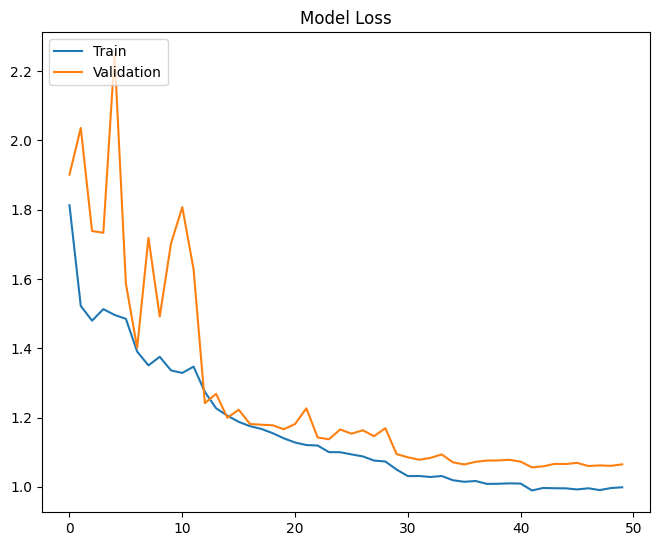

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

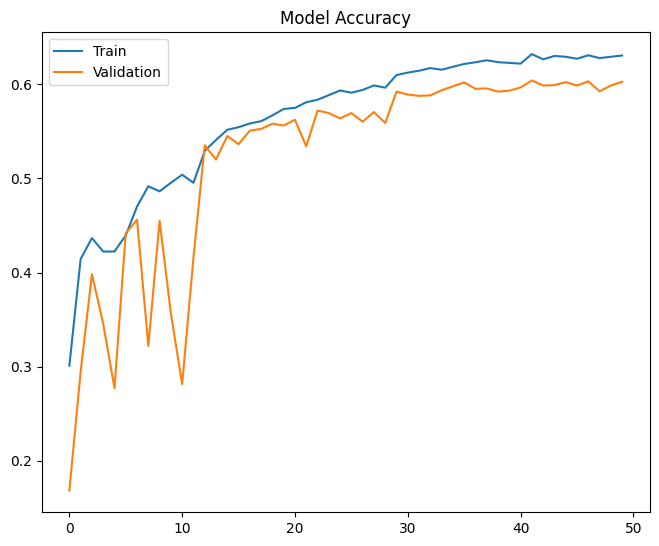

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

In [24]:
def draw_conf_matrix_clas_report(y_true, y_pred, name_labels='', name_model=''):

    c_m = confusion_matrix(y_true, y_pred)
    conf_matrix = pd.DataFrame(c_m, name_labels, name_labels)

    plt.figure(figsize = (9,9))

    group_counts = ['{0:0.0f}'.format(value) for value in
                  conf_matrix.values.flatten()]
    group_percentages = ['{0:.1%}'.format(value) for value in
                        conf_matrix.div(np.sum(conf_matrix, axis=1), axis=0).values.flatten()]

    labels = ['{}\n{}'.format(v1,v2) for v1,v2 in zip(group_counts, group_percentages)]

    labels = np.asarray(labels).reshape(c_m.shape)
    sns.set(font_scale=1.8)
    chart = sns.heatmap(conf_matrix,
              cbar=False ,
              annot=labels,
              square=True,
              fmt='',
              annot_kws={ 'size': 18},
              cmap="Blues",
              )
    chart.set_xticklabels(name_labels)
    chart.set_yticklabels(name_labels, rotation=360, verticalalignment='center')
    plt.savefig('confusion_matrix_{}.png'.format(name_model), bbox_inches='tight', pad_inches=0)

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step


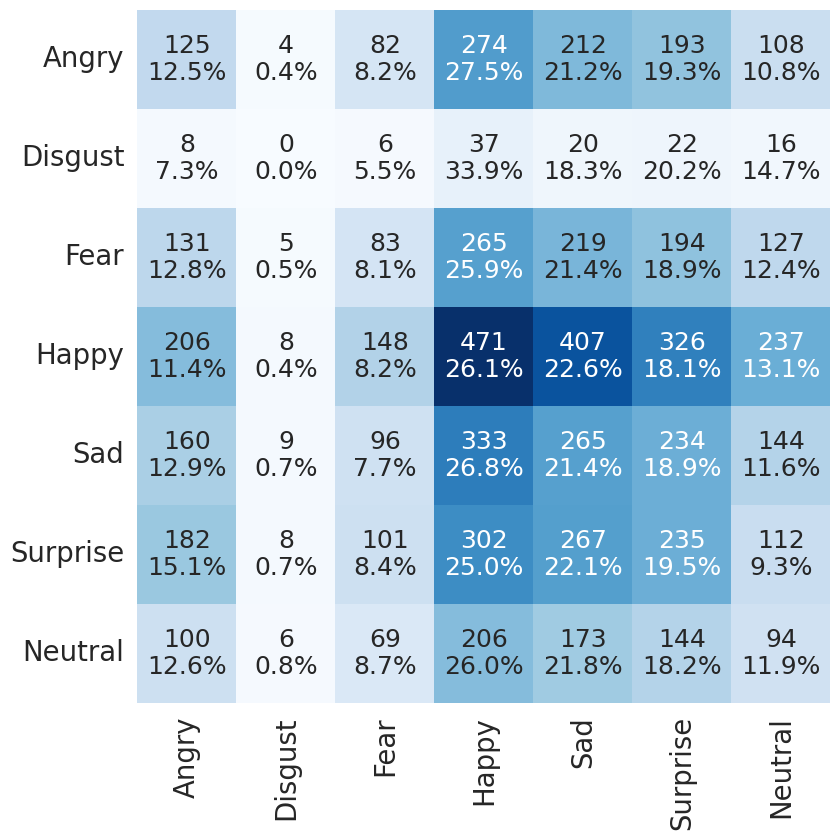

In [25]:
# Evaluate on validation data
val_predict = model.predict(validation_generator)
val_predict = np.argmax(val_predict, axis=1)
val_targ = validation_generator.classes
name_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
draw_conf_matrix_clas_report(val_targ, val_predict, name_labels, 'FER2013')


In [26]:
print(classification_report(val_targ, val_predict, target_names=name_labels, digits=3))

              precision    recall  f1-score   support

       Angry      0.137     0.125     0.131       998
     Disgust      0.000     0.000     0.000       109
        Fear      0.142     0.081     0.103      1024
       Happy      0.249     0.261     0.255      1803
         Sad      0.170     0.214     0.189      1241
    Surprise      0.174     0.195     0.184      1207
     Neutral      0.112     0.119     0.115       792

    accuracy                          0.177      7174
   macro avg      0.141     0.142     0.140      7174
weighted avg      0.173     0.177     0.173      7174



In [28]:
# Create a test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the test set
test_generator = test_datagen.flow_from_directory(
    '/content/test',  # Directory where the test set is stored
    target_size=(height_width, height_width),  # Resize images to match the input size of the model
    batch_size=batch_size,  # Set the batch size
    class_mode='categorical',  # The labels are categorical (7 classes for FER-2013)
    shuffle=False  # Do not shuffle test data, to maintain the order
)


Found 7178 images belonging to 7 classes.


  7/113 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step


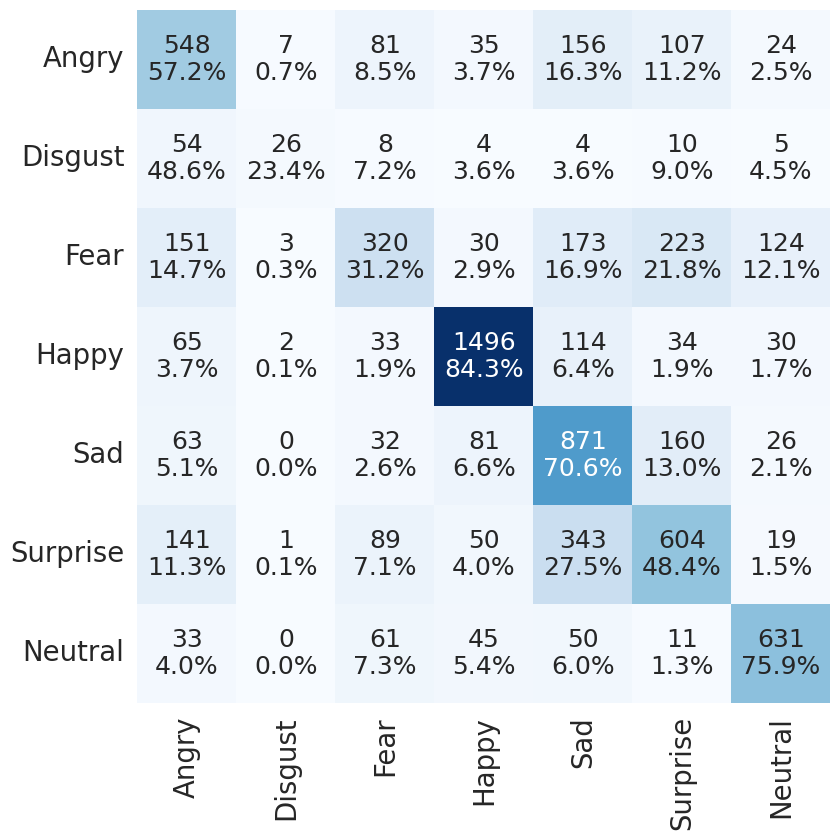

In [29]:
# Evaluate on test data
test_predict = model.predict(test_generator)
test_predict = np.argmax(test_predict, axis=1)
test_targ = test_generator.classes

# Labels for the classes
name_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Generate confusion matrix and classification report for test data
draw_conf_matrix_clas_report(test_targ, test_predict, name_labels, 'FER2013_test')


**Saving Model**

In [30]:
model_json = model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)

In [31]:
# Save the model in TensorFlow/Keras format (e.g., .h5)
model.save('fer2013_model.h5')